##Problem 1

Consider the following two-dimensional diffision problem. Use the discretization below to solve for the

In [1]:
%load_ext tikzmagic

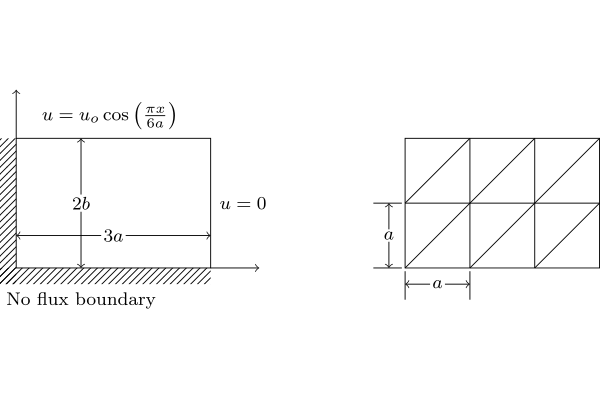

In [2]:
%%tikz --size 600,400 -f svg
\tikzstyle{ann} = [fill=white,font=\footnotesize,inner sep=1pt]
\usetikzlibrary{patterns}
\draw (0.25,0.25) rectangle (3.25,2.25);
\fill [pattern=north east lines] (0,0) rectangle (0.25,2.25);
\fill [pattern=north east lines] (0,0) rectangle (3.25,0.25);
\draw[arrows=->](3.25,0.25)--(4,0.25);
\draw[arrows=->](0.25,2.25)--(0.25,3.0);
\draw[arrows=<->](1.25,0.25)--(1.25,2.25);
\draw[arrows=<->](0.25,0.75)--(3.25,0.75);
\node[ann] at (1.75,0.75) {$3a$};
\node[ann] at (1.25,1.25) {$2b$};
\node[ann] at (3.75,1.25) {$u=0$};
\node[ann] at (1.7,2.6) {$u=u_o \cos\left(\frac{\pi x}{6a}\right)$};
\node[ann] at (1.25,-0.25) {No flux boundary};
%
\draw (6.25,0.25) rectangle (9.25,2.25);
\draw (6.25,1.25) -- (9.25,1.25);
\draw (7.25,0.25) -- (7.25,2.25);
\draw (8.25,0.25) -- (8.25,2.25);
\draw (6.25,0.25) -- (8.25,2.25);
\draw (7.25,0.25) -- (9.25,2.25);
\draw (6.25,1.25) -- (7.25,2.25);
\draw (8.25,0.25) -- (9.25,1.25);
\draw (6.25,0.20) -- (6.25,-0.24);
\draw (7.25,0.20) -- (7.25,-0.24);
\draw (6.2,0.25) -- (5.76,0.25);
\draw (6.2,1.25) -- (5.76,1.25);
\draw[arrows=<->](6,0.25)--(6,1.25);
\draw[arrows=<->](6.25,0)--(7.25,0);
\node[ann] at (6.75,0) {$a$};
\node[ann] at (6,0.75) {$a$};

unknown diffusing concentrations at the nodes with $a = 1$ and $u_o = 100$ assuming a consistent unit system.  The diffusion coefficient matrix is the identity matrix. Perform the following three tasks:

 1. Solve this problem using a direct integration of the trianglur elements. (**20 points**)
 
 2. Solve this problem by using a "parent" element mapping and Gauss integration on the rectangular element (i.e. ignore the triangular elements).  Use a $2 \times 2$ Gauss integration rule. (**20 points**)

 3. Create effective plots to visualize your results from 1 and 2. (**5 points**)

**Note:**  Submit a working version of your code to [Canvas](https://utexas.instructure.com/courses/1119539).  Any supplemental material explaining your answer in part (b) can be turned in to me via hard copy or scanned and submitted to Canvas with your code.

**Solution**

Below we will write the class and methods that will help us solve the problem.

In [3]:
import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

class TwoDimFEM():
    
    def __init__(self, nodes, connect, C=np.array([[1., 0, 0], [0, 1., 0], [0, 0, 0]])):
        """
           Initialize the model.
           
           input: nodes -> the nodal locations as a Numpy array of (x,y) pairs.
           input: connect -> the connectivitiy array
           output: the model problem object
           
        """
        
        self.X = nodes[:,0]
        self.Y = nodes[:,1]
        #Subtract 1 to convert node numbers to be consistent with Numpy 0 indexing
        self.connect = (connect - 1)
        
        self.num_elem = len(self.connect)
        self.num_dof = len(self.X)
        
        self.Cmat = C
        
        #Allocate global tangent and r.h.s vector
        self.K = np.zeros((self.num_dof, self.num_dof), dtype=np.double)
        self.F = np.zeros(self.num_dof, dtype=np.double)
        
    
    def N(self, xi, eta):
        """Compute linear shape functions in natural coordinates."""
        
        return [1 / 4. - eta / 4. - xi / 4. + (eta * xi) / 4.,
                1 / 4. - eta / 4. + xi / 4. - (eta * xi) / 4., 
                1 / 4. + eta / 4. + xi / 4. + (eta * xi) / 4.,
                1 / 4. + eta / 4. - xi / 4. - (eta * xi) / 4.]
        
        
    def dNdxi(self, eta):
        """Compute shape function derivatives with respect to xi"""
        
        return [-1 / 4. + eta / 4., 
                 1 / 4. - eta / 4., 
                 1 / 4. + eta / 4., 
                -1 / 4. - eta / 4.]
                
                
    def dNdeta(self, xi):
        """Compute shape function derivatives with respect to eta"""
        
        return [-1 / 4. + xi / 4.,
                -1 / 4. - xi / 4.,
                 1 / 4. + xi / 4.,
                 1 / 4. - xi / 4.]
    
    
    def compute_jacobian_matrix_and_inverse(self, xi, eta):
        """
           Compute the Jacobian matrix, Det(J) and B for every element
        """
        
        x = self.X
        y = self.Y
        con = self.connect
        
        #Understand we are broadcasting the dot product to every element
        J11 = np.dot(x[con], self.dNdxi(xi))
        J12 = np.dot(y[con], self.dNdxi(xi))
        J21 = np.dot(x[con], self.dNdeta(eta))
        J22 = np.dot(y[con], self.dNdeta(eta))
        
        #detJ is a vector containing the Jacobian determinate for every element
        self.detJ = J11 * J22 - J12 * J21
        
        self.Jinv11 =  J22 / self.detJ
        self.Jinv12 = -J12 / self.detJ
        self.Jinv21 = -J21 / self.detJ
        self.Jinv22 =  J11 / self.detJ
        
        
    def compute_B_matrix(self, xi, eta):
        """Computes the B matrix for a given xi and eta"""
        
        #Returns detJ and Jinv components for this xi and eta
        self.compute_jacobian_matrix_and_inverse(xi, eta)
        
        
        Nmat = np.zeros((3, 4), dtype=np.double)
        Nmat[0,:] = self.dNdxi(xi)
        Nmat[1,:] = self.dNdeta(eta)
        Nmat[2,:] = self.N(xi, eta)
        
        zero = np.zeros(len(self.detJ))
        one = np.ones(len(self.detJ))
        
        Jmat = np.array([[self.Jinv11, self.Jinv12, zero],
                         [self.Jinv21, self.Jinv22, zero],
                         [       zero,        zero,  one]])
        
        #B = J * N
        return np.einsum('jk...,kl', Jmat, Nmat)
    
    
    def compute_stiffness_integrand(self, xi, eta):
        """Computes the integrand of the stiffness matrix for this xi and eta"""
            
        Cmat = self.Cmat
            
        #Returns B
        self.Bmat = self.compute_B_matrix(xi, eta)
            
        #ke_{il} = B_{ji} C_{jk} B_{kl} \det(J)
        return np.einsum('...ji,jk,...kl,...',self.Bmat,Cmat,self.Bmat,self.detJ)
    
    
    def integrate_element_matrices(self):
        """Integrate stiffness matrix with Gauss integration"""
            
        #Use 2 x 2 Gauss integration
        wts = [1., 1.]
        pts = [-np.sqrt(1 / 3.), np.sqrt(1 / 3.)]
            
        ke = np.zeros((self.num_elem, 4, 4))
            
        for i in range(2):
            for j in range(2):
                ke += wts[i] * wts[j] * self.compute_stiffness_integrand(pts[i], pts[j])
                    
        return ke
    
    
    def assemble(self):
        """Assemble element stiffness into global"""
        
        #Check if using natural coordinate quads, if so we will integrate using Gauss integration
        if len(connect[0]) == 4:
        
            ke = self.integrate_element_matrices()
        
            for i in range(self.num_elem):
            
                idx_grid = np.ix_(self.connect[i], self.connect[i])
                self.K[idx_grid]  += ke[i]
        
        #Check if using triangles, if so we will use the analytic stiffness matrix
        elif len(connect[0]) == 3:
            
            c00 = self.Cmat[2,2]
            c11 = self.Cmat[0,0]
            c12 = self.Cmat[0,1]
            c21 = self.Cmat[1,0]
            c22 = self.Cmat[1,1]
            
            ke = np.array([[1 / 12. * (c00 + 6 * (c11 + c12 + c21 + c22)),
                            1 / 24. * (c00 - 12 * (c11 + c21)),
                            1 / 24. * (c00 - 12 * (c12 + c22))],
                           [1 / 24. * (c00 - 12 * (c11 + c12)), 
                            1 / 12. * (c00 + 6 * c11), 
                            1 / 24. * (c00 + 12 * c12)],
                           [1 / 24. * (c00 - 12 * (c21 + c22)), 
                            1 / 24. * (c00 + 12 * c21),
                            1 / 12. * (c00 + 6 * c22)]])
            
            for i in range(self.num_elem):
            
                idx_grid = np.ix_(self.connect[i], self.connect[i])
                self.K[idx_grid]  += ke
            
    
    def apply_essential_bc(self, nodes, values):
        """
           Modifies stiffness matrix and r.h.s. vector for essential b.c.'s
           at location of nodes with corresponding values.
        """
        
        #Subtract 1 to bring the node numbers into alignment with Python indexing
        node_idx = nodes - 1
        
        row_replace = np.zeros(self.num_dof)
        
        for value_idx, node in enumerate(node_idx):        
            
            
            self.K[node] = row_replace
            self.K[node,node] = 1
            
            self.F[node] = values[value_idx]
            
            
    def solve(self):
        """Solve the global system of equations"""
        
        self.K = scipy.sparse.csr_matrix(self.K)
        
        return scipy.sparse.linalg.spsolve(self.K,self.F)

Now we can solve the problem.  I will answer part (2) first using the square elements with linear isoparametric interpolation.

In [4]:
#The node locations
nodes = np.array([[0,0],[1,0],[2,0],[3,0],
                 [0,1],[1,1],[2,1],[3,1],
                 [0,2],[1,2],[2,2],[3,2]], dtype=np.double)

#The connectivity array for the quadratic elements using standard node numbering scheme
connect = np.array([[1, 2, 6, 5],
                   [2, 3, 7, 6],
                   [3, 4, 8, 7],
                   [5, 6, 10, 9],
                   [6, 7, 11, 10],
                   [7, 8, 12, 11]], dtype=np.int64)

#Create a boundary condition node set and vaules for the top side
ns1 = np.array([9, 10, 11, 12], dtype=np.int64)
val1 = np.cos(np.pi * np.array([0., 1., 2., 3.]) / 6.) * 100

#Create a boundary condition node set for the right side
ns2 = np.array([4, 8, 12], dtype=np.int64)
val2 = np.zeros(len(ns2))

#Instatiate the problem
problem = TwoDimFEM(nodes, connect)
#Assemble
problem.assemble()
#Apply boundary conditions
problem.apply_essential_bc(ns1,val1)
problem.apply_essential_bc(ns2,val2)
#Solve
u = problem.solve()
u

array([  61.28417886,   53.07365574,   30.64208943,    0.        ,
         70.29995898,   60.88155036,   35.14997949,    0.        ,
        100.        ,   86.60254038,   50.        ,    0.        ])

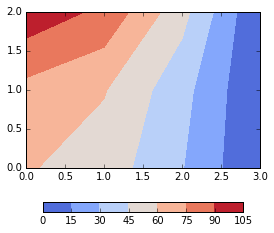

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
#Plot the results
plot = plt.contourf(nodes[:,0].reshape(3,4), nodes[:,1].reshape(3,4), u.reshape(3,4),cmap="coolwarm")
plt.colorbar(plot, orientation='horizontal', shrink=0.6);
plt.clim(0,100)
plt.axes().set_aspect('equal')

Now we will solve part (1) using the triangles and an analytic stiffness matrix

In [6]:
#The node locations are the same, so we will updated the connectivities
connect = np.array([[5, 1, 6],
                    [2, 6, 1],
                    [6, 2, 7],
                    [3, 7, 2],
                    [7, 3, 8],
                    [4, 8, 3],
                    [9, 5, 10],
                    [6, 10, 5],
                    [10, 6, 11],
                    [7, 11, 6],
                    [11, 7, 12],
                    [8, 12, 7]], dtype=np.int64)

#Instantiate the problem
problem = TwoDimFEM(nodes, connect)
#Assemble
problem.assemble()
#Apply boundary conditions
problem.apply_essential_bc(ns1,val1)
problem.apply_essential_bc(ns2,val2)
#Solve
u = problem.solve()

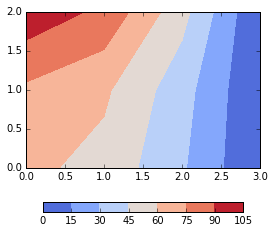

In [7]:
#Plot the results
plot = plt.contourf(nodes[:,0].reshape(3,4), nodes[:,1].reshape(3,4), u.reshape(3,4),cmap="coolwarm")
plt.colorbar(plot, orientation='horizontal', shrink=0.6);
plt.clim(0,100)
plt.axes().set_aspect('equal')